<a href="https://colab.research.google.com/github/denis201520182022/colorization-project/blob/main/notebooks/Train_rgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch torchvision matplotlib opencv-python


In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms.functional import rgb_to_grayscale

In [2]:
class ColorizationDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img_color, _ = self.dataset[idx]
    img_gray = rgb_to_grayscale(img_color)



    return img_gray, img_color



In [3]:

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
train_dataset = ColorizationDataset(train_dataset)
test_dataset = ColorizationDataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s]


Форма grayscale изображений: torch.Size([32, 1, 64, 64])
Форма цветных изображений: torch.Size([32, 3, 64, 64])
torch.Size([3, 64, 64])


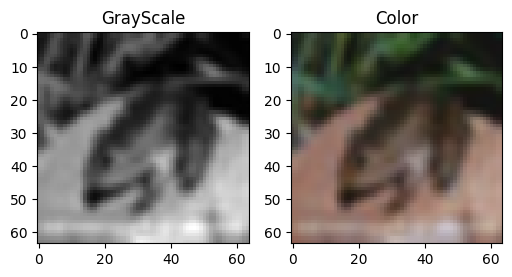

In [4]:

gray_batch, color_batch = next(iter(train_loader))
print("Форма grayscale изображений:", gray_batch.shape)
print("Форма цветных изображений:", color_batch.shape)


plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(gray_batch[0].squeeze(0), cmap='gray')
plt.title('GrayScale')
print(color_batch[0].shape)
plt.subplot(1,2,2)
plt.imshow(color_batch[0].permute(1,2,0))
plt.title('Color')
plt.show()

In [5]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Энкодер: сжимаем информацию
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Декодер: восстанавливаем цвета
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, padding=1, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [7]:
model = ColorizationNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)


#model.load_state_dict("colorization_weights_lab_V2.pth")
#optimizer.load_state_dict('optimizer_weights_lab_V2.pth')

cuda


In [8]:


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for gray_img, color_img in progress_bar:
        gray_img, color_img = gray_img.to(device), color_img.to(device)
        optimizer.zero_grad()
        output = model(gray_img)
        loss = criterion(output, color_img)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10: 100%|██████████| 1563/1563 [00:32<00:00, 47.87it/s]


Epoch [1/10] Loss: 0.0075


Epoch 2/10: 100%|██████████| 1563/1563 [00:32<00:00, 47.88it/s]


Epoch [2/10] Loss: 0.0063


Epoch 3/10: 100%|██████████| 1563/1563 [00:32<00:00, 48.36it/s]


Epoch [3/10] Loss: 0.0061


Epoch 4/10: 100%|██████████| 1563/1563 [00:31<00:00, 49.92it/s]


Epoch [4/10] Loss: 0.0060


Epoch 5/10: 100%|██████████| 1563/1563 [00:31<00:00, 49.58it/s]


Epoch [5/10] Loss: 0.0058


Epoch 6/10: 100%|██████████| 1563/1563 [00:31<00:00, 50.32it/s]


Epoch [6/10] Loss: 0.0057


Epoch 7/10: 100%|██████████| 1563/1563 [00:31<00:00, 49.84it/s]


Epoch [7/10] Loss: 0.0056


Epoch 8/10: 100%|██████████| 1563/1563 [00:31<00:00, 48.88it/s]


Epoch [8/10] Loss: 0.0056


Epoch 9/10: 100%|██████████| 1563/1563 [00:31<00:00, 49.67it/s]


Epoch [9/10] Loss: 0.0055


Epoch 10/10: 100%|██████████| 1563/1563 [00:31<00:00, 49.95it/s]

Epoch [10/10] Loss: 0.0055


In [12]:
torch.save(model.state_dict(), 'colorization_model_rgb.pth')
torch.save(optimizer.state_dict(), 'optimizer_weights_rgb.pth')

from google.colab import files
files.download("colorization_model_rgb.pth")
files.download("optimizer_weights_rgb.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:



model.eval()
test_loss = 0.0

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="")
    for gray_img, color_img in progress_bar:

        gray_img = gray_img.to(device).float()
        color_img = color_img.to(device).float()

        outputs = model(gray_img)

        loss = criterion(outputs, color_img)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {average_test_loss:.4f}')

100%|██████████| 313/313 [00:05<00:00, 61.46it/s]

Test Loss: 0.0054
